In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 

# Importing the database

In [2]:
df = pd.read_pickle("preprocessedLeafDB.pkl")

In [3]:
msk = np.random.rand(len(df)) < 0.8

trainset = df[msk]

testset = df[~msk]

In [4]:
testvalues = (testset.values.tolist())

cleaned_test_set = []
temp = trainset.values.tolist()
#i = 0
for i in range(len(testset)):
    tenseur = torch.tensor(testvalues[i][1]/255)
    classification = list.index(testvalues[i][2:40], 1)
    cleaned_test_set.append((tenseur, classification))
    
trainvalues = (trainset.values.tolist())
cleaned_train_set = []
for i in range(len(trainset)):
    tenseur = torch.tensor(trainvalues[i][1]/255)
    classification = list.index(trainvalues[i][2:40], 1)
    cleaned_train_set.append((tenseur, classification))
    
    

In [5]:
import torchvision
from torchvision.transforms import transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(cleaned_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(cleaned_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11','12', '13', '14', '15', '16', '17', '18', '19', '20',
           '21','22', '23', '24', '25', '26', '27', '28', '29', '30', '31','32', '33', '34', '35', '36', '37')


# Creating the neural network's architecture

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(1, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(cleaned_train_set, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = torch.transpose(inputs, 0, 2)
        inputs = torch.transpose(inputs, 1, 2)
        inputs = torch.unsqueeze(inputs, 0) #adding fake batch
        #print(inputs.size())
        #inputs = inputs.view(1, -1)
        inputs = inputs.type('torch.DoubleTensor')
        inputs = inputs.float()
        outputs = net(inputs)
        labels = torch.tensor([labels])
        #print(labels)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.364
[1,   400] loss: 0.364
[1,   600] loss: 0.364
[1,   800] loss: 0.364
[1,  1000] loss: 0.362
[1,  1200] loss: 0.361
[1,  1400] loss: 0.361
[2,   200] loss: 0.345
[2,   400] loss: 0.315
[2,   600] loss: 0.264
[2,   800] loss: 0.193
[2,  1000] loss: 0.159
[2,  1200] loss: 0.121
[2,  1400] loss: 0.088
Finished Training


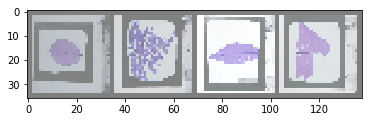

   32    27    23    22


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = torch.transpose(images, 1, 3)
images = torch.transpose(images, 2, 3)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

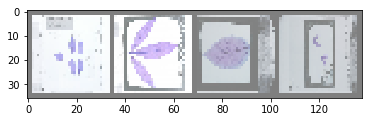

GroundTruth:     19    14    35    37


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images = torch.transpose(images, 1, 3)
images = torch.transpose(images, 2, 3)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Testing

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        #modifications
        #print(images.size())
        images = torch.transpose(images, 1, 3)
        #print(images.size())
        images = torch.transpose(images, 2, 3)
        #print(images.size())
        #labels = torch.tensor([labels])
        
        images = images.type('torch.DoubleTensor')
        images = images.float()
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 82 %


In [13]:
class_correct = list(0. for i in range(38))
class_total = list(0. for i in range(38))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        #modifications
        images = torch.transpose(images, 1, 3)
        images = torch.transpose(images, 2, 3)
        #labels = torch.tensor([labels])
        
        images = images.type('torch.DoubleTensor')
        images = images.float()
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        if(c.size()== torch.Size([4])):
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

for i in range(38):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i] if (class_total[i] != 0) else -1))

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 33 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 71 %
Accuracy of     9 : 100 %
Accuracy of    10 : 100 %
Accuracy of    11 : 100 %
Accuracy of    12 : 100 %
Accuracy of    13 : 100 %
Accuracy of    14 : 100 %
Accuracy of    15 : 100 %
Accuracy of    16 : 100 %
Accuracy of    17 : 100 %
Accuracy of    18 : 100 %
Accuracy of    19 : 33 %
Accuracy of    20 :  0 %
Accuracy of    21 : 25 %
Accuracy of    22 : 45 %
Accuracy of    23 : 100 %
Accuracy of    24 : 100 %
Accuracy of    25 :  0 %
Accuracy of    26 : 100 %
Accuracy of    27 :  0 %
Accuracy of    28 : 100 %
Accuracy of    29 : 100 %
Accuracy of    30 : 100 %
Accuracy of    31 : 80 %
Accuracy of    32 : 100 %
Accuracy of    33 : 100 %
Accuracy of    34 : 100 %
Accuracy of    35 : 100 %
Accuracy of    36 :  0 %
Accuracy of    37 : 100 %


# testing on new images

In [14]:
df = pd.read_csv("C:/Users/Qnouro/Desktop/Programming/Scrapper/leavesDatabase/leaf.csv", 
                  names = ["image array", "type 1", "type2"])

In [15]:
#One Hot Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df.dropna(inplace=True)

data = df['type 1']

values = np.array(data)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# invert first example
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
inverted = label_encoder.inverse_transform([32])


c:\users\qnouro\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Manually testing

In [16]:
import random
import cv2

random.seed(10)
random_list = [random.randint(0, len(df.iloc[:, 1:2].values)) for _ in range(20)]


img_path = "C:/Users/Qnouro/Desktop/Programming/Scrapper/leavesDatabase/"

end_path = ".jpg"

img_array = []


for i in random_list:
    ##img reading
    read_img = cv2.imread(img_path +str(i)+ end_path)
    #resizing
    size = (32, 32)
    fit_and_resized_image = cv2.resize(read_img, dsize=size, interpolation=cv2.INTER_CUBIC)
    img_array.append(fit_and_resized_image)
    
    ##prediction
    images = fit_and_resized_image
    images = torch.tensor(images)
    #modifications
    images = torch.transpose(images, 0, 2)
    images = torch.transpose(images, 1, 2)
    images = torch.unsqueeze(images, 0) #adding fake batch
    images = images.type('torch.DoubleTensor')
    images = images.float()

    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    ##decoding label
    prediction_label = label_encoder.inverse_transform([predicted])[0]

    print(f"expected : {df.iloc[i, 1:2].values[0]}")
    print(f"predicted : {prediction_label}\n")

expected : aceraceae
predicted : hamamelidaceae

expected : magnoliaceae
predicted : tetrameristaceae

expected : bombacaceae
predicted : burseraceae

expected : rubiaceae
predicted : acanthaceae

expected : verbenaceae
predicted : rubiaceae

expected : malvaceae
predicted : menispermaceae

expected : aceraceae
predicted : acanthaceae

expected : annonaceae
predicted : annonaceae

expected : malpighiaceae
predicted : sapindaceae

expected : actinidiaceae
predicted : annonaceae

expected : aceraceae
predicted : acanthaceae

expected : aceraceae
predicted : burseraceae

expected : rubiaceae
predicted : hamamelidaceae

expected : aceraceae
predicted : annonaceae

expected : malvaceae
predicted : fagaceae

expected : aceraceae
predicted : phytolaccaceae

expected : hamamelidaceae
predicted : aceraceae

expected : tiliaceae
predicted : fagaceae

expected : magnoliaceae
predicted : rubiaceae

expected : moraceae 
predicted : apocynaceae

